# Discovering the Poisson Equation with SR-DEC

In this tutorial, we are going to see how to discover the **1D Poisson equation** using `flex` and **SR-DEC**, a new symbolic regression strategy developed in the paper [Discovering interpretable physical models using symbolic regression and discrete exterior calculus
](https://iopscience.iop.org/article/10.1088/2632-2153/ad1af2/meta). 
The 1D Poisson equation is a second-order elliptic partial differential equation that models steady-state diffusion processes such as heat conduction, electrostatics, and gravitational potential in one spatial dimension. It is typically written as  
$$\frac{d^2 u(x)}{dx^2} + f(x) = 0, \quad x \in (a,b),$$
where $u(x)$is the unknown scalar field and $f(x)$ is a given source term. To obtain a unique solution, the equation must be complemented with appropriate boundary conditions, such as Dirichlet conditions at $x=a$ and $x=b$. 
The 1D Poisson equation admits a natural **variational (weak) formulation**, that is under mild assumptions on $f$ finding the solution of the Poisson equation is equivalent on minimizing the Dirichlet functional
$$\mathcal{F}(u) := \int_a^b (u'(x))^2\,dx - \int_a^b f(x)\,u(x)\,dx$$
under some Dirichlet boundary conditions.
The mathematical language used to discretize the variational and non-variational formulation of the Poisson equation is **Discrete Exterior Calculus**. The (discrete) Poisson equation is then written as
$$\delta d u + f = 0 \quad \text{or equivalently} \quad \star d \star d u + f = 0,$$
and its variational formulation becomes
$$\mathcal{F}(u) := \langle du, du \rangle - \langle u, f \rangle = \langle \delta du, u \rangle - \langle u, f \rangle.$$

For the non-variational formulation, the SR strategy discovers the LHS of the equation, while in the variational case the goal is finding the Dirichlet functional. The DEC language is handled by [`dctkit`](https://github.com/cpml-au/dctkit). 

## Imports and Dependencies

In [1]:
from dctkit.dec import cochain as C
from dctkit.mesh.simplex import SimplicialComplex
from dctkit.mesh.util import generate_line_mesh, build_complex_from_mesh
from dctkit.math.opt import optctrl as oc
from deap import gp
from flex.gp import regressor as gps
from flex.gp.util import compile_individuals
from dctkit import config
import dctkit
import numpy as np
import ray
import math
from typing import Tuple, Callable, List
import os
from flex.gp.util import load_config_data
from flex.gp.primitives import add_primitives_to_pset_from_dict

import matplotlib.pyplot as plt

In [2]:
# choose precision and whether to use GPU or CPU
# needed for context of the plots at the end of the evolution
os.environ["JAX_PLATFORMS"] = "cpu"
config()

In [12]:
# def compile_individuals(toolbox, individuals_str_batch):
#     return [toolbox.compile(expr=ind) for ind in individuals_str_batch]

In [3]:
def eval_MSE_sol(
    individual: Callable, X, y, S: SimplicialComplex, u_0: C.CochainP0, residual_mode: bool ="True"
) -> float:

    num_nodes = S.num_nodes

    # need to call config again before using JAX in energy evaluations to make sure that
    # the current worker has initialized JAX
    os.environ["JAX_PLATFORMS"] = "cpu"
    config()

    if residual_mode:
        # objective: squared norm of the residual of the equation + penalty on Dirichlet
        # boundary condition on the first node
        def obj(x, y):
            penalty = 100.0 * x[0] ** 2
            u = C.CochainP0(S, x)
            f = C.CochainP0(S, y)
            r = individual(u, f)
            total_energy = C.inner(r, r) + penalty
            return total_energy
    else:
        # objective: variational formulation of the equation + penalty on Dirichlet
        # boundary condition on the first node
        def obj(x, y):
            penalty = 100.0 * x[0] ** 2
            u = C.CochainP0(S, x)
            f = C.CochainP0(S, y)
            total_energy = individual(u, f) + penalty
            return total_energy

    prb = oc.OptimizationProblem(dim=num_nodes, state_dim=num_nodes, objfun=obj)

    MSE = 0.0

    # set additional arguments of the objective function
    # (apart from the vector of unknowns)
    args = {"y": X}
    prb.set_obj_args(args)

    # minimize the objective
    u = prb.solve(x0=u_0.coeffs.flatten(), ftol_abs=1e-12, ftol_rel=1e-12, maxeval=1000)

    if y is not None:
        if (
            prb.last_opt_result == 1
            or prb.last_opt_result == 3
            or prb.last_opt_result == 4
        ):
            MSE = np.mean(np.linalg.norm(u - y) ** 2)
        else:
            MSE = math.nan

        if math.isnan(MSE):
            MSE = 1e5

    return MSE, [u]

In [4]:
def get_features_batch(individ_feature_extractors, individuals_str_batch):
    features_batch = [
        [fe(i) for i in individuals_str_batch] for fe in individ_feature_extractors
    ]

    indlen = features_batch[0]
    return indlen

In [5]:
def predict(
    individuals_str: list[str],
    toolbox,
    X,
    S: SimplicialComplex,
    u_0: C.CochainP0,
    residual_mode: bool,
    penalty: dict,
) -> List:

    callables = compile_individuals(toolbox, individuals_str)

    u = [None] * len(individuals_str)

    for i, ind in enumerate(callables):
        _, u[i] = eval_MSE_sol(ind, X, None, S, u_0, residual_mode)

    return u


def score(
    individuals_str: list[str],
    toolbox,
    X,
    y,
    S: SimplicialComplex,
    u_0: C.CochainP0,
    residual_mode: bool,
    penalty: dict,
) -> List:

    callables = compile_individuals(toolbox, individuals_str)

    MSE = [None] * len(individuals_str)

    for i, ind in enumerate(callables):
        MSE[i], _ = eval_MSE_sol(ind, X, y, S, u_0, residual_mode)

    return MSE


def fitness(
    individuals_str: list[str],
    toolbox,
    X,
    y,
    S: SimplicialComplex,
    u_0: C.CochainP0,
    residual_mode: bool,
    penalty: dict,
) -> Tuple[float,]:

    callables = compile_individuals(toolbox, individuals_str)
    indlen = get_features_batch([len], individuals_str)

    fitnesses = [None] * len(individuals_str)
    for i, ind in enumerate(callables):
        MSE, _ = eval_MSE_sol(ind, X, y, S, u_0, residual_mode)

        # add penalty on length of the tree to promote simpler solutions
        fitnesses[i] = (MSE + penalty["reg_param"] * indlen[i],)

    return fitnesses

## Training Pipeline

In [6]:
filename = "sr_dec.yaml"
residual_mode = True

regressor_params, config_file_data = load_config_data(filename)

# generate mesh and dataset
mesh, _ = generate_line_mesh(num_nodes=11, L=1.0)
S = build_complex_from_mesh(mesh)
S.get_hodge_star()
x = S.node_coords
num_nodes = S.num_nodes

# generate training and test datasets
# exact solution = x²
u = C.CochainP0(S, np.array(x[:, 0] ** 2, dtype=dctkit.float_dtype))
# compute source term such that u solves the discrete Poisson equation
# Delta u + f = 0, where Delta is the discrete Laplace-de Rham operator
f = C.laplacian(u)
f.coeffs *= -1.0

X_train = np.array(f.coeffs.ravel(), dtype=dctkit.float_dtype)
y_train = np.array(u.coeffs.ravel(), dtype=dctkit.float_dtype)

# initial guess for the unknown of the Poisson problem (cochain of nodals values)
u_0_vec = np.zeros(num_nodes, dtype=dctkit.float_dtype)
u_0 = C.CochainP0(S, u_0_vec)

# define primitive set for the residual of the discrete Poisson equation
if residual_mode:
    pset = gp.PrimitiveSetTyped("RESIDUAL", [C.CochainP0, C.CochainP0], C.CochainP0)
else:
    pset = gp.PrimitiveSetTyped("RESIDUAL", [C.CochainP0, C.CochainP0], float)

# rename arguments of the residual
pset.renameArguments(ARG0="u")
pset.renameArguments(ARG1="f")

pset = add_primitives_to_pset_from_dict(pset, config_file_data["gp"]["primitives"])


penalty = config_file_data["gp"]["penalty"]
common_params = {"S": S, "u_0": u_0, "penalty": penalty, "residual_mode": residual_mode}

gpsr = gps.GPSymbolicRegressor(
    pset_config=pset,
    fitness=fitness,
    score_func=score,
    predict_func=predict,
    print_log=True,
    common_data=common_params,
    seed_str=None,
    save_best_individual=True,
    save_train_fit_history=True,
    output_path="./",
    remove_init_duplicates=True,
    **regressor_params
)

gpsr.fit(X_train, y_train, X_val=X_train, y_val=y_train)

u_best = gpsr.predict(X_train)

fit_score = gpsr.score(X_train, y_train)

gpsr.save_best_test_sols(X_train, "./")

ray.shutdown()

2026-01-15 11:55:48,377	INFO worker.py:2007 -- Started a local Ray instance.


Generating initial population(s)...
 Removing duplicates from initial population(s)...
 DONE.
DONE.
Evaluating initial population(s)...
DONE.
 -= START OF EVOLUTION =- 
   	     	           fitness            	             size             
   	     	------------------------------	------------------------------
gen	evals	min   	avg   	max   	std   	min	avg 	max	std   
1  	20   	2.8333	3.2583	3.8333	0.2755	3  	7.25	13 	2.7545
Best individuals of this generation:
St1D1(St1P0(u))
2  	20   	2.8333	3.0133	3.2333	0.1166	3  	4.8 	7  	1.1662
Best individuals of this generation:
St1D1(St1P0(u))
3  	20   	2.8333	2.8933	3.0333	0.0917	3  	3.6 	5  	0.9165
Best individuals of this generation:
St1D1(St1P0(u))
4  	20   	2.8333	2.8333	2.8333	0     	3  	3   	3  	0     
Best individuals of this generation:
St1D1(St1P0(u))
5  	20   	2.8333	2.8333	2.8333	0     	3  	3   	3  	0     
Best individuals of this generation:
St1D1(St1P0(u))
6  	20   	2.8333	2.8333	2.8333	0     	3  	3   	3  	0     
Best individuals

## Plots

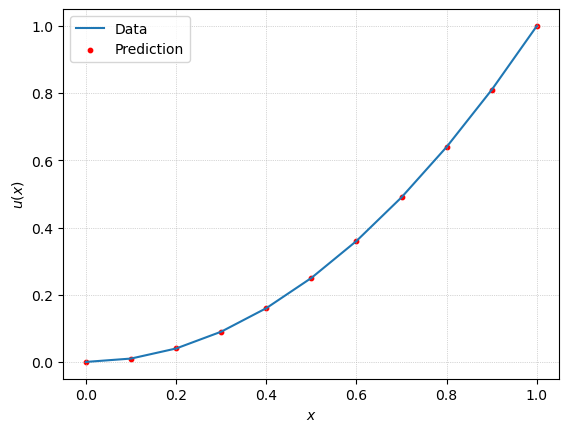

In [23]:
plt.plot(x[:,0], y_train, label="Data")
plt.scatter(x[:,0], u_best, c="r", s=10, label="Prediction")
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.grid(True, linestyle=":", linewidth=0.5)
plt.legend()
plt.show()